# Hypertrophic Cardiomyopathy Genes Cross-Validation
##### Selin Kubali

## Goal
Choose a threshold to differentiate high-risk and low-risk individuals for HCM, where such a threshold is appropriate.

 
#### How the code functions
Cross-validation is done on patient information and builds a model which predicts how likely each patient is to develop HCM. We use Youden's index to choose the best threshold, while ensuring there is at least 1 HCM case among both low-risk and high-risk patients to assist in fitting. We then run a Cox regression model with patient risk grouping as the only coefficient to determine the success of the thresholding approach. 
Cross-validation is done by splitting on variant data, to ensure there are an equal number of variants in each fold and prevent overfitting on high-frequency variants.


#### Inputs
Lifelines files - Stored in */selected_genes/hcm/cox_model_data*. 
Variant data files - Stored in */selected_genes/hcm/variant_files*.
Clinvar data - Stored in */selected_genes/hcm/csv_files/variant_summary.txt*

#### Load packages

In [16]:
!pip install lifelines --quiet --root-user-action=ignore
!pip install scikit-learn --quiet --root-user-action=ignore
!pip install matplotlib --quiet --root-user-action=ignore
!pip install statsmodels --quiet --root-user-action=ignore
!pip install seaborn --quiet --root-user-action=ignore
!pip install brokenaxes --quiet --root-user-action=ignore

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
import brokenaxes

from lifelines import plotting
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

from statsmodels.stats.multitest import multipletests
from scipy.stats import percentileofscore
from matplotlib import rcParams
from brokenaxes import brokenaxes


plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica') 
plt.rcParams.update({'font.size': 14})
warnings.filterwarnings("ignore")

### Extract ClinVar information

In [ ]:
!dx download /selected_genes/hcm/csv_files/variant_summary.txt.gz
!gzip -d variant_summary.txt.gz

### Cross-validation
Cross validation can be performed either on variant-level features (AlphaMissense, Ensembl consequence, CADD, PhyloP, SpliceAI, REVEL, and population maximum allele frequency), patient- and variant-level features (previously mentioned variant-level features + PRS, hypertension, Afib, family history of CAD, and sex).

In [35]:
def cross_val(gene, only_variant_info = False):
        """ Load variant data, individual patient data, and clinvar data. Runs cross-validation on individual patient data to predict risk of developing HCM. Cleans and joins files and returns a file with individual patient data, individual patient hazard scores, and Clinvar pathogenicity data. Only perform cross-validation if there are at least 5 HCM cases among patients with missense or LOF variants.
        """


        cph = CoxPHFitter(penalizer = 0.001)
        
        
        
        # load lifelines file
        lifelines_data = pd.read_csv(f'/mnt/project/selected_genes/hcm/cox_model_data/{gene}_with_generated_data.csv', 
                                     dtype = {'duration':'float', 'is_CM':'boolean', 'sex':'boolean',
                                              'is_family_hist':'boolean', 'is_AF':'boolean',
                                              'is_HTN': 'boolean', 'am_pathogenicity':'float'})
        

        # normalizes scores
        lifelines_data['prs_score'] = (lifelines_data['prs_score'] - lifelines_data['prs_score'].min()) / (lifelines_data['prs_score'].max() - lifelines_data['prs_score'].min())     
        lifelines_data['am_pathogenicity'] = (lifelines_data['am_pathogenicity'] - lifelines_data['am_pathogenicity'].min()) / (lifelines_data['am_pathogenicity'].max() - lifelines_data['am_pathogenicity'].min())     
        lifelines_data['cadd_raw_score'] = (lifelines_data['cadd_raw_score'] - lifelines_data['cadd_raw_score'].min()) / (lifelines_data['cadd_raw_score'].max() - lifelines_data['cadd_raw_score'].min())     
        lifelines_data['phylop'] = (lifelines_data['phylop'] - lifelines_data['phylop'].min()) / (lifelines_data['phylop'].max() - lifelines_data['phylop'].min())     
        lifelines_data['faf_max'] = (lifelines_data['faf_max'] - lifelines_data['faf_max'].min()) / (lifelines_data['faf_max'].max() - lifelines_data['faf_max'].min())     
        lifelines_data['revel_max'] = (lifelines_data['revel_max'] - lifelines_data['revel_max'].min()) / (lifelines_data['revel_max'].max() - lifelines_data['revel_max'].min())     


        # filtering to only patients with variants
        lifelines_data = lifelines_data[lifelines_data['Consequence'].isin(['synonymous_variant','deleterious','missense_variant'])]

        # encoding consequencing into AlphaMissense
        lifelines_data.loc[lifelines_data['Consequence'] == 'deleterious', 'am_pathogenicity'] = 1
        lifelines_data.loc[lifelines_data['Consequence'] == 'synonymous_variant', 'am_pathogenicity'] = 0
        
        
        if len(lifelines_data[(lifelines_data['Consequence'].isin(['deleterious','missense_variant']) & (lifelines_data['is_HCM'] == 1))]) > 5:
        
            variant_level_features = ['am_pathogenicity','cadd_raw_score','faf_max','phylop','spliceai_ds_max','revel_max']

            demographic_level_features = ['is_HTN', 'is_AF', 'prs_score', 'sex', 'is_family_hist']
            if only_variant_info == True:
                lifelines_data = lifelines_data[['Name', 'Carrier', 'duration', 'is_HCM'] + variant_level_features]
            else:
                lifelines_data = lifelines_data[['Name', 'Carrier', 'duration', 'is_HCM'] + variant_level_features + demographic_level_features]


            # load variant data file
            variant_data = pd.read_csv(f'/mnt/project/selected_genes/hcm/variant_files/{gene}_variants.csv')

            variant_data_name = variant_data[['Name']]
            variant_data_name= variant_data_name.dropna()

            # set lifelines data index to variant data index
            variant_data_name['var_index'] = variant_data_name.index
            lifelines_data = variant_data_name.merge(lifelines_data, how="outer")
            lifelines_data.set_index("var_index")
            lifelines_data=lifelines_data.dropna()
            lifelines_data = lifelines_data.drop_duplicates(subset=['Carrier'])


            # load, clean, and merge clinvar information
            clinvar_df = pd.read_csv('variant_summary.txt', sep = '\t', dtype = {'Chromosome':'str'})
            clinvar_df = clinvar_df[clinvar_df['Assembly'] == 'GRCh38']
            clinvar_df = clinvar_df.rename(columns={"Chromosome": "Chrom", "Start": "Pos", "ReferenceAlleleVCF": "Ref", "AlternateAlleleVCF": "Alt"})
            clinvar_df = clinvar_df[["Name", "Chrom", "Pos", "Ref", "Alt", "ClinicalSignificance"]]
            clinvar_variant_df = pd.merge(variant_data, clinvar_df, how = 'left', on = ['Pos', 'Ref', 'Alt'])
            clinvar_variant_df = clinvar_variant_df.rename(columns={"Name_x": "Name"})
            clinvar_variant_df = clinvar_variant_df[["Name", "ClinicalSignificance"]]
            lifelines_data = pd.merge(lifelines_data,clinvar_variant_df, how="left", on = ['Name'])
            lifelines_data = lifelines_data.drop_duplicates(subset=['Carrier'])

        
            # cross validation: split up phenotypic data file based on variant file index
            kf = KFold(n_splits=5, shuffle=True, random_state=4)
            testing_set = []
            for train_idx, test_idx in kf.split(variant_data):

                    train = lifelines_data[lifelines_data['var_index'].isin(train_idx)]
                    test = lifelines_data[lifelines_data['var_index'].isin(test_idx)]
                    train = train.drop(['var_index'], axis=1)
                    test = test.drop(['var_index'], axis=1)


                    # fit CPH and add hazard scores
                    if only_variant_info == True:
                        cph.fit(train, duration_col="duration", event_col="is_HCM", fit_options = {"step_size":0.1}, formula = variant_level_features)
                    else:
                        cph.fit(train, duration_col="duration", event_col="is_HCM", fit_options = {"step_size":0.1}, formula = variant_level_features + demographic_level_features)

                    hazard_scores_fold = cph.predict_partial_hazard(test)
                    test['hazard'] = hazard_scores_fold
                    testing_set.append(test)

            # create new lifelines_data df by joining all testing sets
            lifelines_data = pd.concat([df for idx, df in enumerate(testing_set)]) 
        
        else:
            lifelines_data = pd.DataFrame()
            print("Too few cases")

        return lifelines_data 


#### Display Kaplan-Meier graphs and calculate Cox regression fit by patient risk group

In [36]:
def vus_kmf_graph(gene, threshold, lifelines_data, lifelines_data_synonymous, hazard):
    """Graph hazard scores against synonymous variants and benign, VUS, and pathogenic Clinvar variants. 
    Patients carrying VUS variants are divided by the chosen threshold and plotted on Kaplan-Meier curves."""
    
    
    lifelines_data_pathogenic = lifelines_data[(lifelines_data['ClinicalSignificance'].isin(['Pathogenic', 'Pathogenic/Likely pathogenic', 'Likely pathogenic']))]
    lifelines_data_benign = lifelines_data[(lifelines_data['ClinicalSignificance'].isin(['Benign', 'Likely benign', 'Benign/Likely benign']))]
    lifelines_data_vus = lifelines_data[~lifelines_data['ClinicalSignificance'].isin(['Benign', 'Likely benign', 'Benign/Likely benign', 'Pathogenic', 'Likely pathogenic', 'Pathogenic/Likely pathogenic'])]
    

    # Compare patients above threshold with patients below threshold
    bottom = lifelines_data[lifelines_data['hazard'] <= hazard]
    top = lifelines_data[lifelines_data['hazard'] > hazard]
    case_count = len(lifelines_data[lifelines_data['is_HCM'] == 1])
    dfA = pd.DataFrame({'E': bottom['is_HCM'], 'T': bottom['duration'], 'is_highest': 0})
    dfB = pd.DataFrame({'E': top['is_HCM'], 'T': top['duration'], 'is_highest': 1})
    df = pd.concat([dfA, dfB])
    cph = CoxPHFitter().fit(df, 'T', 'E', fit_options = {"step_size":0.1})
    cph.print_summary()

    result_p = "{:.{}g}".format(cph.summary['p'].at['is_highest'], 2)
    result_exp = "{:.{}g}".format(cph.summary['exp(coef)'].at['is_highest'], 2)


    print('Threshold by percentile: ', threshold)
    fig, axs = plt.subplots(1, 1, figsize=(6, 5))
    fig.suptitle(gene, fontsize=22, y = 1)

    # KMF graphs for all patients with non-synonymous variants
    kmf_top = KaplanMeierFitter(label = 'High risk')
    kmf_top.fit(top['duration'], top['is_HCM'])
    kmf_top.plot(ax=axs, color = '#f55f74') 

    kmf_bottom = KaplanMeierFitter(label = 'Low risk')
    kmf_bottom.fit(bottom['duration'], bottom['is_HCM'])
    kmf_bottom.plot(ax=axs, color = '#0d7d87')
    
    lifelines_data_vus_low = lifelines_data_vus[lifelines_data_vus['hazard'] < hazard]
    lifelines_data_vus_high = lifelines_data_vus[lifelines_data_vus['hazard'] > hazard]
    kmf_vus_high = KaplanMeierFitter(label = 'VUS high risk')
    kmf_vus_high.fit(lifelines_data_vus_high['duration'], lifelines_data_vus_high['is_HCM'])
    kmf_vus_high.plot(ax=axs, color = '#f55f74', linestyle='--') 
    
    kmf_vus_low = KaplanMeierFitter(label = 'VUS low risk')
    kmf_vus_low.fit(lifelines_data_vus_low['duration'], lifelines_data_vus_low['is_HCM'])
    kmf_vus_low.plot(ax=axs, color = '#0d7d87', linestyle='--')
    
    axs.set_xlim(0, 80)
    axs.set_title('Low and high risk for all patients')
    axs.set_ylabel('Percent without HCM')
    axs.set_xlabel('Age')
    plotting.add_at_risk_counts(kmf_bottom, kmf_top, kmf_vus_low, kmf_vus_high , ax = axs, rows_to_show = ['At risk'], xticks = [40, 60, 80])


    
    dfA = pd.DataFrame({'E': lifelines_data_vus_low['is_HCM'], 'T': lifelines_data_vus_low['duration'], 'is_highest': 0})
    dfB = pd.DataFrame({'E': lifelines_data_vus_high['is_HCM'], 'T': lifelines_data_vus_high['duration'], 'is_highest': 1})
    df = pd.concat([dfA, dfB])
    cph = CoxPHFitter().fit(df, 'T', 'E', fit_options = {"step_size":0.1})
    
    result_p_vus = "{:.{}g}".format(cph.summary['p'].at['is_highest'], 2)
    result_exp_vus = "{:.{}g}".format(cph.summary['exp(coef)'].at['is_highest'], 2)

    results_dict = {'Gene':gene, 'Threshold':threshold,'Partial hazard for all patients':result_exp, 'P-value for all patients': result_p, 'Partial hazard for patients with VUS': result_exp_vus, 'P-value for patients with VUS': result_p_vus, 'Num. carrier cases':case_count}
    print('Number of VUS above threshold: ', len(lifelines_data_vus[lifelines_data_vus['hazard'] > hazard]))
    
    # Box plots by hazard score for patient with synonymous, benign, VUS, and pathogenic variants
    data = [np.log(lifelines_data_pathogenic['hazard']), np.log(lifelines_data_vus['hazard']), np.log(lifelines_data_benign['hazard']), np.log(lifelines_data_synonymous['hazard'])]

        
    return kmf_vus_low, kmf_vus_high, data, results_dict

    


##### Perform thresholding

In [56]:
def find_threshold_vals(genes, only_variant_info = False):
    
        """ Runs CoxPH cross-validation and choose a threshold based on the returned hazard scores """

        results_df = pd.DataFrame()
        for gene in genes:
            print(gene)

                
            # running cross-validation
            
            if only_variant_info == True:
                print("Model with only variant-level features")
                lifelines_data = cross_val(gene, only_variant_info = True)
            else:
                print("Model with all features")
                lifelines_data = cross_val(gene)
                
            if len(lifelines_data) == 0:
                continue
                
            # filter out synonymous variants
            lifelines_data_synonymous = lifelines_data[(lifelines_data['am_pathogenicity'] == 0)]
            lifelines_data = lifelines_data[(lifelines_data['am_pathogenicity'] != 0)]


    
            lifelines_data_pathogenic = lifelines_data[(lifelines_data['ClinicalSignificance'].isin(['Pathogenic', 'Pathogenic/Likely pathogenic', 'Likely pathogenic']))]
            lifelines_data_benign = lifelines_data[(lifelines_data['ClinicalSignificance'].isin(['Benign', 'Likely benign', 'Benign/Likely benign']))]
            lifelines_data_vus = lifelines_data[~lifelines_data['ClinicalSignificance'].isin(['Benign', 'Likely benign', 'Benign/Likely benign', 'Pathogenic', 'Likely pathogenic', 'Pathogenic/Likely pathogenic', 'Conflicting interpretations of pathogenicity'])]
            lifelines_data.reset_index(inplace = True)

            lifelines_data['is_HCM'] = lifelines_data['is_HCM'].astype('int64')


            hazard = None


            fpr, tpr, thresholds = metrics.roc_curve(lifelines_data['is_HCM'], lifelines_data['hazard'], pos_label = 1)
            roc_auc = metrics.auc(fpr, tpr)
            
            # calculating threshold  
            lifelines_data_vus = lifelines_data[~lifelines_data['ClinicalSignificance'].isin(['Benign', 'Likely benign', 'Benign/Likely benign', 'Pathogenic', 'Likely pathogenic', 'Pathogenic/Likely pathogenic'])]
            vus_hazard_min = lifelines_data_vus[lifelines_data_vus['is_HCM'] == 1]['hazard'].min()
            vus_hazard_max = lifelines_data_vus[lifelines_data_vus['is_HCM'] == 1]['hazard'].max()
            min_index = np.argmin(np.abs(np.array(thresholds)-vus_hazard_min)) # vus min should be larger than any other variable
            max_index = np.argmin(np.abs(np.array(thresholds)-vus_hazard_max))
            tpr_limited = tpr[max_index:min_index]
            fpr_limited = fpr[max_index:min_index]

            thresholds = thresholds[max_index:min_index]
            optimal_idx = np.argmax(tpr_limited - fpr_limited)
            hazard = thresholds[optimal_idx]
            
            threshold = int(percentileofscore(lifelines_data['hazard'], hazard))


            # plotting
            
            kmf_vus_low, kmf_vus_high, data, results_dict = vus_kmf_graph(gene, threshold, lifelines_data, lifelines_data_synonymous, hazard)
            results_dict = pd.DataFrame(results_dict, index = [gene])
            results_df = pd.concat([results_df, pd.DataFrame(results_dict)], ignore_index = True)


            fig = plt.figure(constrained_layout=True, figsize=(21, 7))
            axs = fig.subplot_mosaic([['Left', 'Middle', 'Right']])

            plt.rcParams.update({'font.size': 20})

            axs['Left'].tick_params(axis='x', which='both', labelsize=20)
            axs['Left'].tick_params(axis='y', which='both', labelsize=20)
            axs['Left'].set_yticklabels(['P/LP'+'\n'+'n='+str(len(lifelines_data_pathogenic)), 'VUS'+'\n'+'n='+str(len(lifelines_data_vus)), 'B/LB'+'\n'+'n='+str(len(lifelines_data_benign)), 'Syn'+'\n'+'n='+str(len(lifelines_data_synonymous))])
            axs['Left'].get_xaxis().tick_bottom()
            axs['Left'].get_yaxis().tick_left()
            axs['Left'].axvline(np.log(hazard), color='#fb8072', linestyle='--', label = 'Threshold')
            axs['Left'].legend()
            axs['Left'].set_xlabel("Log hazard score", fontdict={'fontsize':24})
            axs['Left'].set_ylabel("Clinvar pathogenicity", fontdict={'fontsize':24})
            axs['Left'].set_title("Hazard score by Clinvar", fontdict={'fontsize':24})
            colors = ['#28adcb','#28adcb','#28adcb','#28adcb']
            boxplot = axs['Left'].boxplot(data, patch_artist=True, vert=0)

            for patch, color in zip(boxplot['boxes'], colors):
                patch.set_facecolor(color)

                
            axs['Middle'].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc, color = '#28adcb')
            #axs['BottomRight'].axline([0, 0], [1, 1], ls="--", color = '#808080',label = 'Random classifier')
            axs['Middle'].plot(fpr[optimal_idx], tpr[optimal_idx],'ro',color='#fb8072', label = 'Threshold') 
            axs['Middle'].legend()
            axs['Middle'].set_xlabel('False positive rate', fontdict={'fontsize':24}) 
            axs['Middle'].set_ylabel('True positive rate', fontdict={'fontsize':24}) 
            axs['Middle'].set_title("ROC", fontdict={'fontsize':24})
            axs['Middle'].tick_params(axis='x', which='both', labelsize=20)
            axs['Middle'].tick_params(axis='y', which='both', labelsize=20)
            
            axs['Right'].tick_params(axis='x', which='both', labelsize=20)
            axs['Right'].tick_params(axis='y', which='both', labelsize=20)
            kmf_vus_low.plot(ax=axs['Right'], color = '#0d7d87')
            kmf_vus_high.plot(ax=axs['Right'], color = '#f55f74')
            axs['Right'].set_xlim(30, 80)
            axs['Right'].set_title('Patients with low- and high-risk VUS', fontdict={'fontsize':24})
            axs['Right'].set_ylabel('Percent without HCM', fontdict={'fontsize':24})
            axs['Right'].set_xlabel('Age', fontdict={'fontsize':24})
            plotting.add_at_risk_counts(kmf_vus_low, kmf_vus_high, ax = axs['Right'], rows_to_show = ['At risk'], xticks = [40, 60, 80])
            #axs['BottomLeft'].text(0.1, 0.2, 'p-value: '+str(results_dict['P-value for patients with VUS'][gene]), backgroundcolor = 'white', transform=fig.transFigure)

   

            plt.tight_layout()

            plt.show()
                
                
        
                
        return results_df
                


In [57]:
gene_list = ['ACTC1', 'ACTN2', 'ALPK3','DES','FLNC','MYBPC3','MYH6','MYH7','MYL2','MYL3','PLN','PTPN11','TNNI3','TNNT2','TPM1','TTR']

ALPK3
Model with only variant-level features


<lifelines.CoxPHFitter: fitted with 14930 total observations, 14891 right-censored observations>
             duration col = 'duration'
                event col = 'is_HCM'
                penalizer = 0.001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 14930
number of events observed = 39
   partial log-likelihood = -351.34
         time fit was run = 2024-07-02 15:23:18 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
am_pathogenicity  1.09      2.97      0.50            0.12            2.06                1.12                7.86
cadd_raw_score    0.90      2.45      1.14           -1.34            3.13                0.26               22.83
faf_max          -0.08      0.92      0.47           -1.00            0.83                0.37                2.30
phylop           -0.62      0.54      0.95           -2.48            1.25                0.08                3.48
spliceai_ds_max   0.34      1.40      1.17           -1.95            2.62                0.14               13.79
revel_max        -0.48      0.62      1.18           -2.80            1.83                0.06                6.26

                  cmp to     z    p  -log2(p)
covariate                                    
am_pathogenicity    0.00  2.20 0.03      5.16
cadd_raw_score      0.00  0.79 0.43      1.21
faf_max             0.00 -0.18 0.86      0.22
phylop              0.00 -0.65 0.52      0.96
spliceai_ds_max     0.00  0.29 0.77      0.37
revel_max           0.00 -0.41 0.68      0.55
---
Concordance = 0.57
Partial AIC = 714.68
log-likelihood ratio test = 8.95 on 6 df
-log2(p) of ll-ratio test = 2.50

<lifelines.CoxPHFitter: fitted with 10736 total observations, 10706 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 10736
number of events observed = 30
   partial log-likelihood = -259.66
         time fit was run = 2024-07-02 15:23:21 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
is_highest  1.01      2.73      0.37            0.28            1.74                1.32                5.67

            cmp to    z    p  -log2(p)
covariate                             
is_highest    0.00 2.70 0.01      7.16
---
Concordance = 0.60
Partial AIC = 521.33
log-likelihood ratio test = 6.58 on 1 df
-log2(p) of ll-ratio test = 6.60

Threshold by percentile:  80
Number of VUS above threshold:  1987


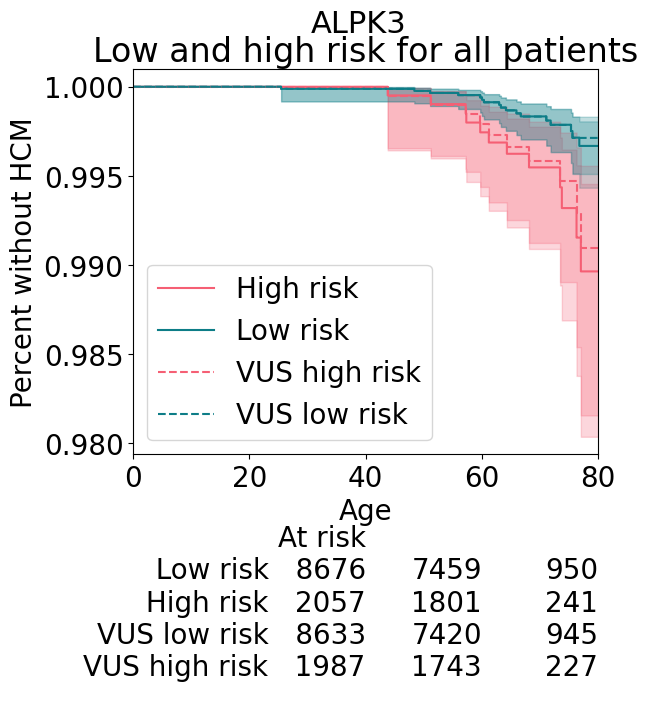

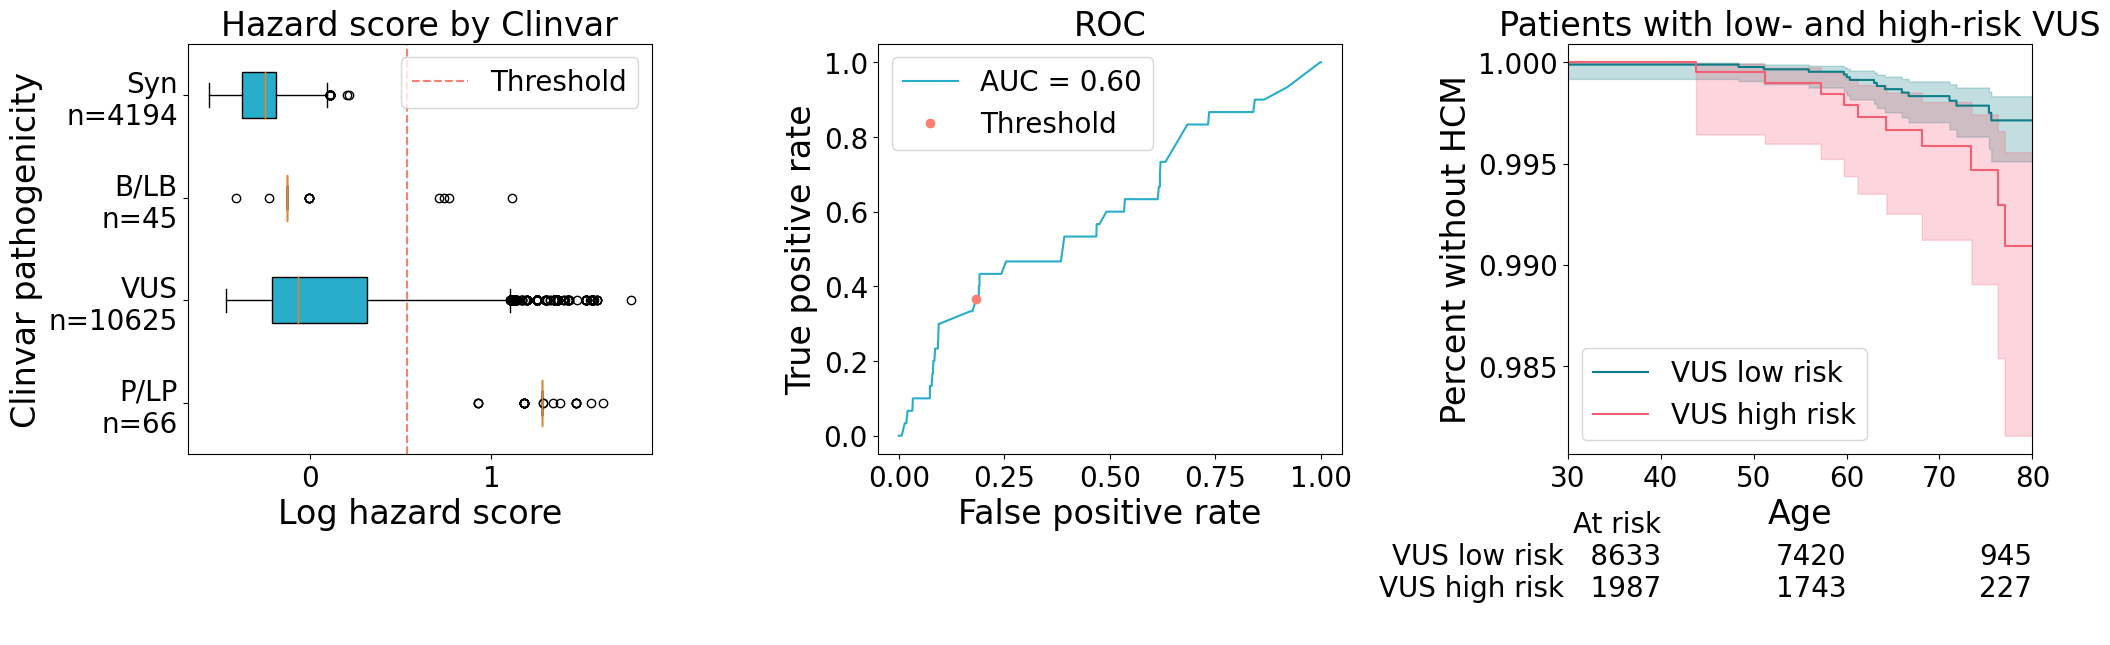

FLNC
Model with only variant-level features


<lifelines.CoxPHFitter: fitted with 17251 total observations, 17215 right-censored observations>
             duration col = 'duration'
                event col = 'is_HCM'
                penalizer = 0.001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 17251
number of events observed = 36
   partial log-likelihood = -329.04
         time fit was run = 2024-07-02 15:24:05 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
am_pathogenicity -0.17      0.84      0.51           -1.18            0.83                0.31                2.30
cadd_raw_score    0.78      2.18      1.32           -1.81            3.37                0.16               29.04
faf_max          -0.75      0.47      0.55           -1.83            0.34                0.16                1.40
phylop            0.12      1.12      0.78           -1.42            1.65                0.24                5.22
spliceai_ds_max  -1.15      0.32      1.32           -3.73            1.44                0.02                4.23
revel_max         0.91      2.47      0.60           -0.26            2.07                0.77                7.96

                  cmp to     z    p  -log2(p)
covariate                                    
am_pathogenicity    0.00 -0.33 0.74      0.44
cadd_raw_score      0.00  0.59 0.56      0.85
faf_max             0.00 -1.35 0.18      2.49
phylop              0.00  0.15 0.88      0.18
spliceai_ds_max     0.00 -0.87 0.39      1.38
revel_max           0.00  1.52 0.13      2.95
---
Concordance = 0.67
Partial AIC = 670.09
log-likelihood ratio test = 10.14 on 6 df
-log2(p) of ll-ratio test = 3.07

<lifelines.CoxPHFitter: fitted with 10798 total observations, 10770 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 10798
number of events observed = 28
   partial log-likelihood = -242.40
         time fit was run = 2024-07-02 15:24:08 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
is_highest  0.85      2.34      0.38            0.11            1.59                1.11                4.91

            cmp to    z    p  -log2(p)
covariate                             
is_highest    0.00 2.24 0.03      5.31
---
Concordance = 0.62
Partial AIC = 486.80
log-likelihood ratio test = 4.78 on 1 df
-log2(p) of ll-ratio test = 5.12

Threshold by percentile:  72
Number of VUS above threshold:  2931


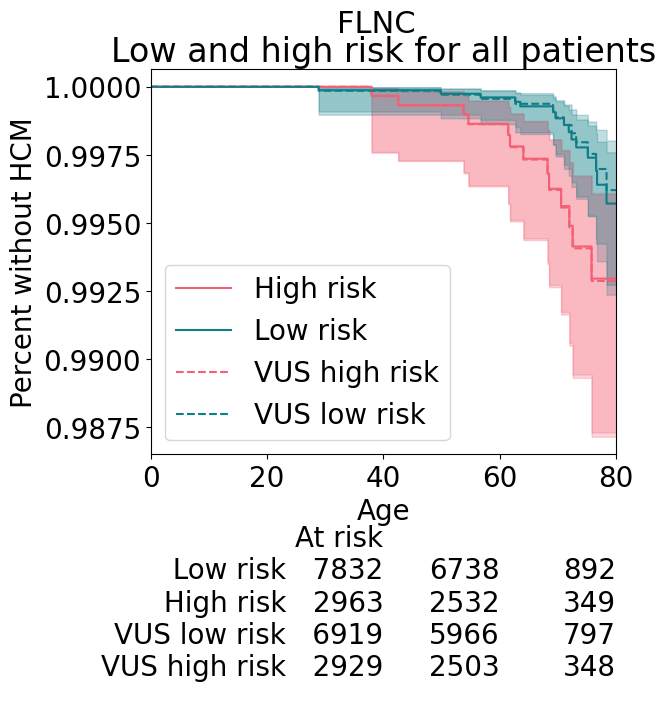

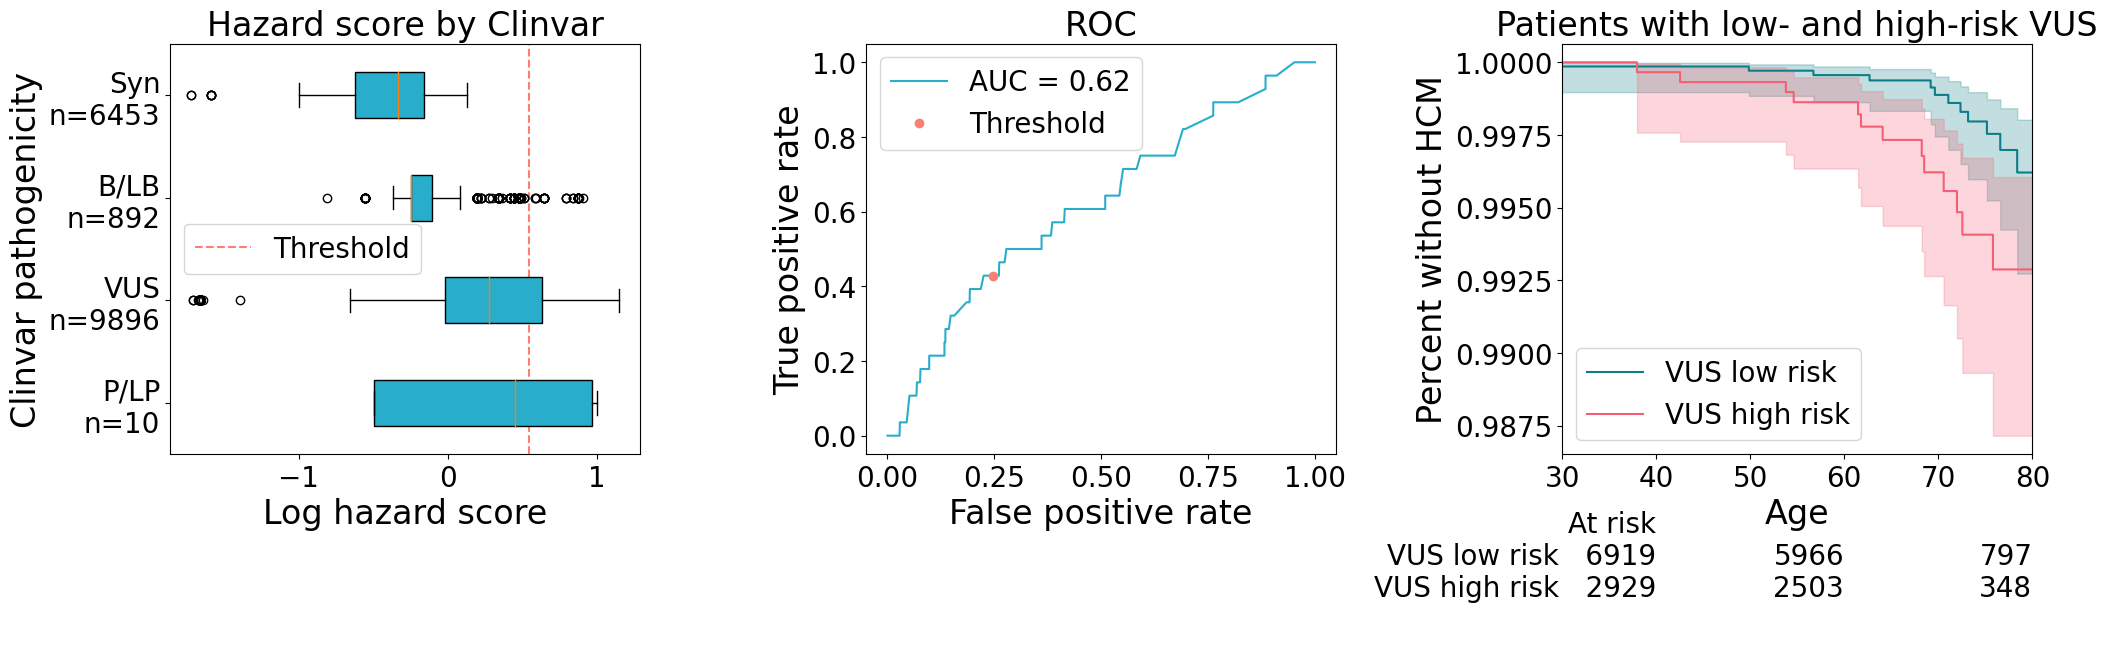

MYBPC3
Model with only variant-level features


<lifelines.CoxPHFitter: fitted with 11111 total observations, 11051 right-censored observations>
             duration col = 'duration'
                event col = 'is_HCM'
                penalizer = 0.001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 11111
number of events observed = 60
   partial log-likelihood = -476.04
         time fit was run = 2024-07-02 15:24:52 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
am_pathogenicity  2.09      8.07      0.43            1.24            2.94                3.44               18.89
cadd_raw_score    4.34     76.97      0.89            2.59            6.09               13.39              442.49
faf_max          -1.68      0.19      0.53           -2.72           -0.65                0.07                0.52
phylop           -3.37      0.03      0.63           -4.61           -2.13                0.01                0.12
spliceai_ds_max   0.50      1.65      0.55           -0.58            1.58                0.56                4.87
revel_max         0.21      1.24      0.51           -0.79            1.21                0.46                3.36

                  cmp to     z      p  -log2(p)
covariate                                      
am_pathogenicity    0.00  4.81 <0.005     19.32
cadd_raw_score      0.00  4.87 <0.005     19.75
faf_max             0.00 -3.19 <0.005      9.44
phylop              0.00 -5.32 <0.005     23.22
spliceai_ds_max     0.00  0.90   0.37      1.45
revel_max           0.00  0.42   0.68      0.57
---
Concordance = 0.84
Partial AIC = 964.07
log-likelihood ratio test = 123.07 on 6 df
-log2(p) of ll-ratio test = 77.84

<lifelines.CoxPHFitter: fitted with 7984 total observations, 7929 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 7984
number of events observed = 55
   partial log-likelihood = -416.23
         time fit was run = 2024-07-02 15:24:56 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
is_highest  3.26     26.03      0.27            2.72            3.80               15.23               44.49

            cmp to     z      p  -log2(p)
covariate                                
is_highest    0.00 11.92 <0.005    106.40
---
Concordance = 0.77
Partial AIC = 834.45
log-likelihood ratio test = 118.39 on 1 df
-log2(p) of ll-ratio test = 89.18

Threshold by percentile:  94
Number of VUS above threshold:  264


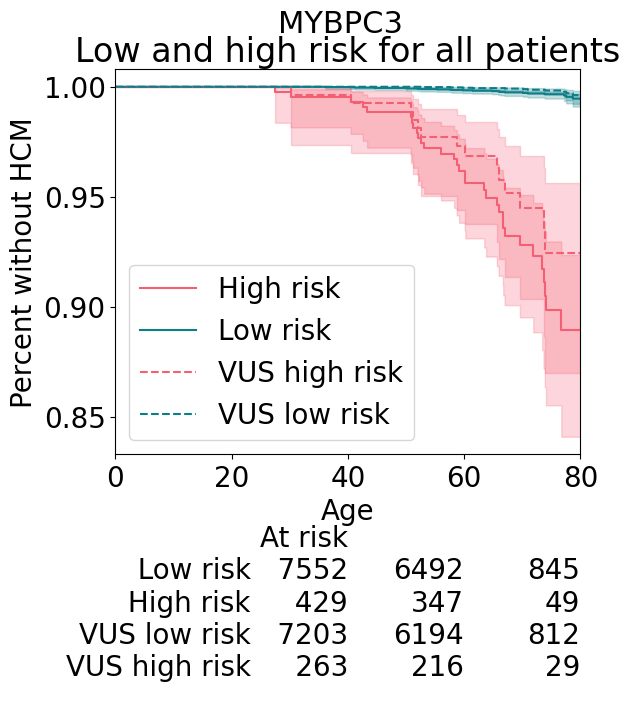

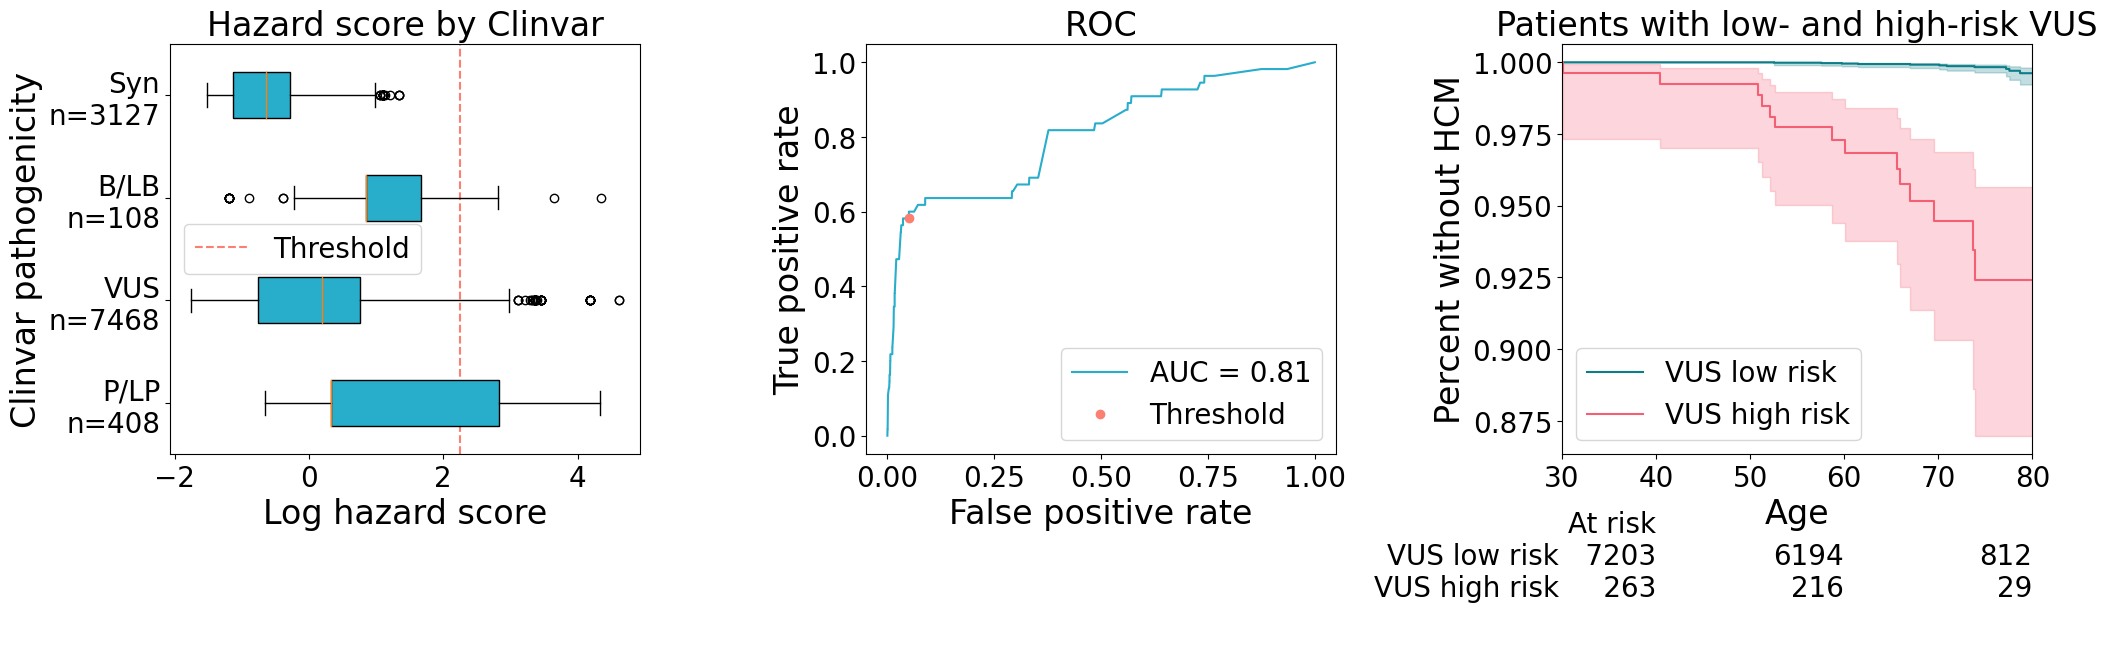

MYH7
Model with only variant-level features


<lifelines.CoxPHFitter: fitted with 11721 total observations, 11666 right-censored observations>
             duration col = 'duration'
                event col = 'is_HCM'
                penalizer = 0.001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 11721
number of events observed = 55
   partial log-likelihood = -456.75
         time fit was run = 2024-07-02 15:25:41 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
am_pathogenicity  0.02      1.02      0.40           -0.76            0.79                0.47                2.21
cadd_raw_score    1.01      2.75      1.25           -1.44            3.46                0.24               31.97
faf_max          -0.61      0.54      0.66           -1.90            0.69                0.15                1.98
phylop            1.55      4.70      0.85           -0.12            3.22                0.89               24.91
spliceai_ds_max  -2.09      0.12      1.37           -4.78            0.59                0.01                1.80
revel_max         1.70      5.46      0.54            0.64            2.76                1.89               15.76

                  cmp to     z      p  -log2(p)
covariate                                      
am_pathogenicity    0.00  0.04   0.97      0.05
cadd_raw_score      0.00  0.81   0.42      1.25
faf_max             0.00 -0.92   0.36      1.49
phylop              0.00  1.82   0.07      3.85
spliceai_ds_max     0.00 -1.53   0.13      2.99
revel_max           0.00  3.14 <0.005      9.19
---
Concordance = 0.80
Partial AIC = 925.50
log-likelihood ratio test = 57.56 on 6 df
-log2(p) of ll-ratio test = 32.73

<lifelines.CoxPHFitter: fitted with 5313 total observations, 5266 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 5313
number of events observed = 47
   partial log-likelihood = -365.90
         time fit was run = 2024-07-02 15:25:44 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
is_highest  1.45      4.28      0.31            0.85            2.06                2.34                7.83

            cmp to    z      p  -log2(p)
covariate                               
is_highest    0.00 4.73 <0.005     18.74
---
Concordance = 0.68
Partial AIC = 733.79
log-likelihood ratio test = 23.99 on 1 df
-log2(p) of ll-ratio test = 19.98

Threshold by percentile:  68
Number of VUS above threshold:  1423


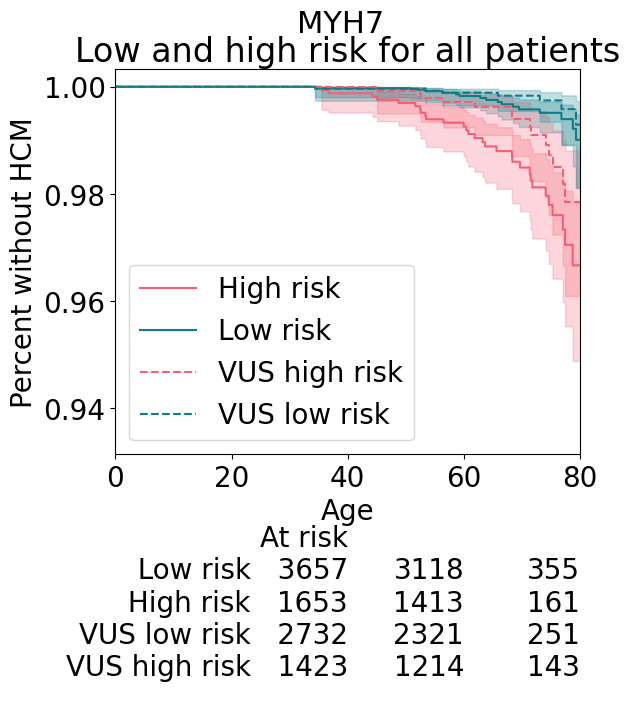

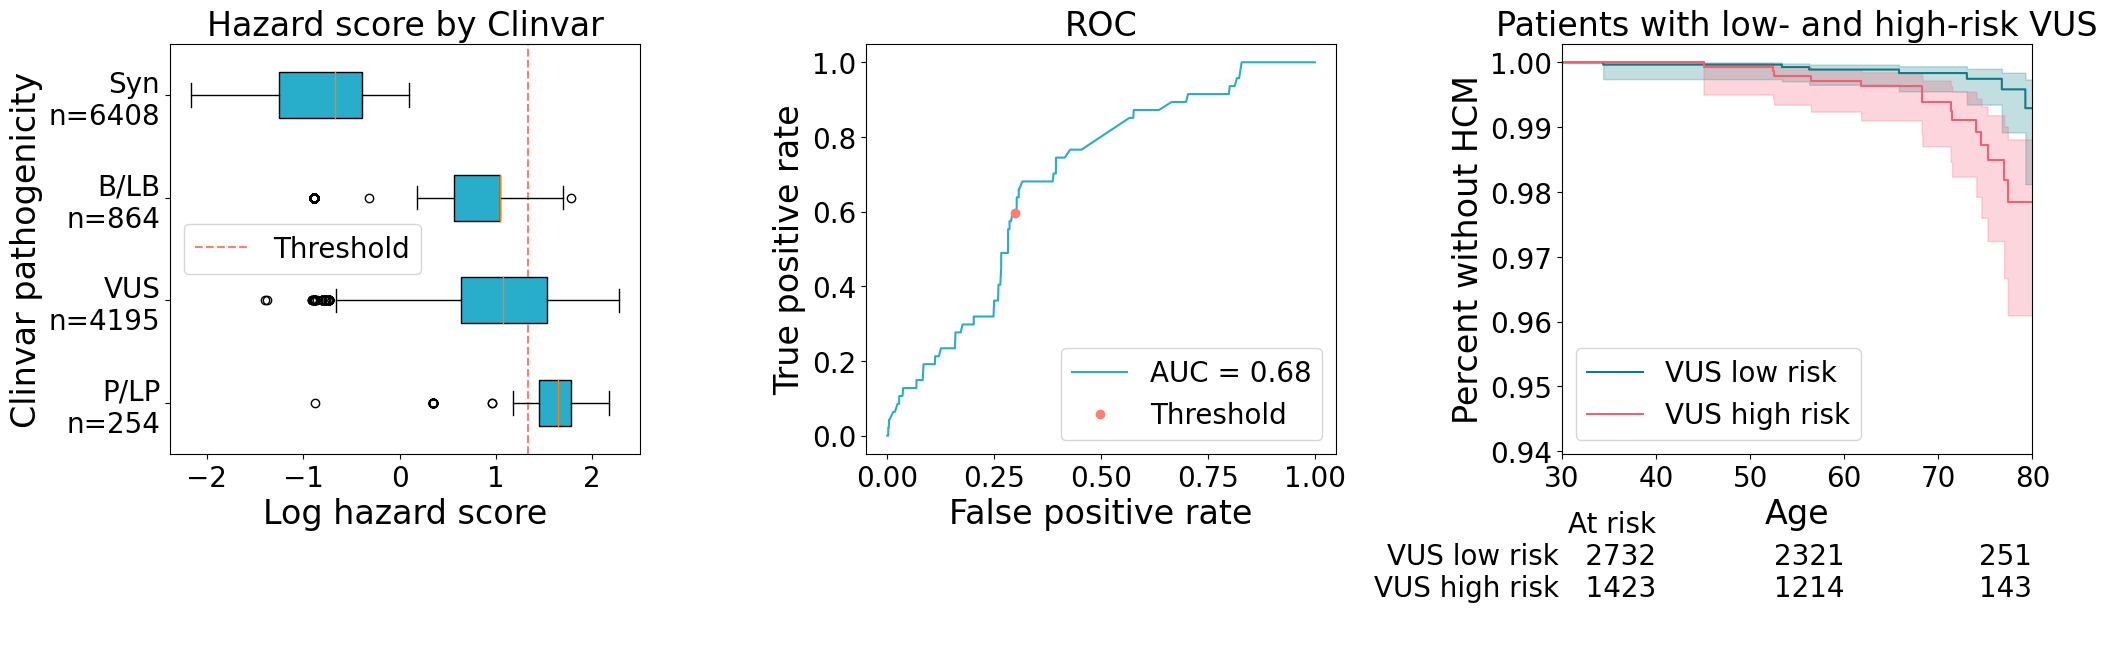

,Gene,Threshold,Partial hazard for all patients,P-value for all patients,Partial hazard for patients with VUS,P-value for patients with VUS,Num. carrier cases
0,ALPK3,80,2.7,0.007,2.5,0.022,30
1,FLNC,72,2.3,0.025,2.6,0.017,28
2,MYBPC3,94,26,9.4e-33,37,3e-19,55
3,MYH7,68,4.3,2.3e-06,4,0.0023,47


In [59]:
find_threshold_vals(gene_list, only_variant_info = True)

ALPK3
Model with all features


<lifelines.CoxPHFitter: fitted with 14798 total observations, 14759 right-censored observations>
             duration col = 'duration'
                event col = 'is_HCM'
                penalizer = 0.001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 14798
number of events observed = 39
   partial log-likelihood = -326.31
         time fit was run = 2024-07-02 15:27:35 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
am_pathogenicity  1.14      3.12      0.50            0.15            2.12                1.17                8.34
cadd_raw_score    0.73      2.08      1.13           -1.48            2.95                0.23               19.17
faf_max          -0.04      0.96      0.47           -0.95            0.88                0.39                2.40
phylop           -0.54      0.58      0.94           -2.38            1.29                0.09                3.65
spliceai_ds_max   0.42      1.52      1.18           -1.90            2.73                0.15               15.40
revel_max        -0.46      0.63      1.17           -2.76            1.83                0.06                6.26
is_HTN            1.21      3.34      0.32            0.58            1.83                1.79                6.25
is_AF             1.13      3.10      0.37            0.41            1.85                1.51                6.36
prs_score         3.53     34.10      1.21            1.15            5.91                3.16              368.28
sex               0.81      2.25      0.29            0.24            1.38                1.27                3.99
is_family_hist    0.42      1.52      0.28           -0.12            0.96                0.89                2.62

                  cmp to     z      p  -log2(p)
covariate                                      
am_pathogenicity    0.00  2.27   0.02      5.41
cadd_raw_score      0.00  0.65   0.52      0.95
faf_max             0.00 -0.08   0.94      0.10
phylop              0.00 -0.58   0.56      0.83
spliceai_ds_max     0.00  0.35   0.72      0.47
revel_max           0.00 -0.40   0.69      0.53
is_HTN              0.00  3.78 <0.005     12.66
is_AF               0.00  3.09 <0.005      8.95
prs_score           0.00  2.91 <0.005      8.10
sex                 0.00  2.79   0.01      7.55
is_family_hist      0.00  1.52   0.13      2.96
---
Concordance = 0.87
Partial AIC = 674.61
log-likelihood ratio test = 58.36 on 11 df
-log2(p) of ll-ratio test = 25.67

<lifelines.CoxPHFitter: fitted with 10636 total observations, 10606 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 10636
number of events observed = 30
   partial log-likelihood = -242.08
         time fit was run = 2024-07-02 15:27:38 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
is_highest  2.87     17.56      0.61            1.67            4.06                5.32               57.96

            cmp to    z      p  -log2(p)
covariate                               
is_highest    0.00 4.70 <0.005     18.58
---
Concordance = 0.80
Partial AIC = 486.16
log-likelihood ratio test = 41.21 on 1 df
-log2(p) of ll-ratio test = 32.76

Threshold by percentile:  70
Number of VUS above threshold:  3113


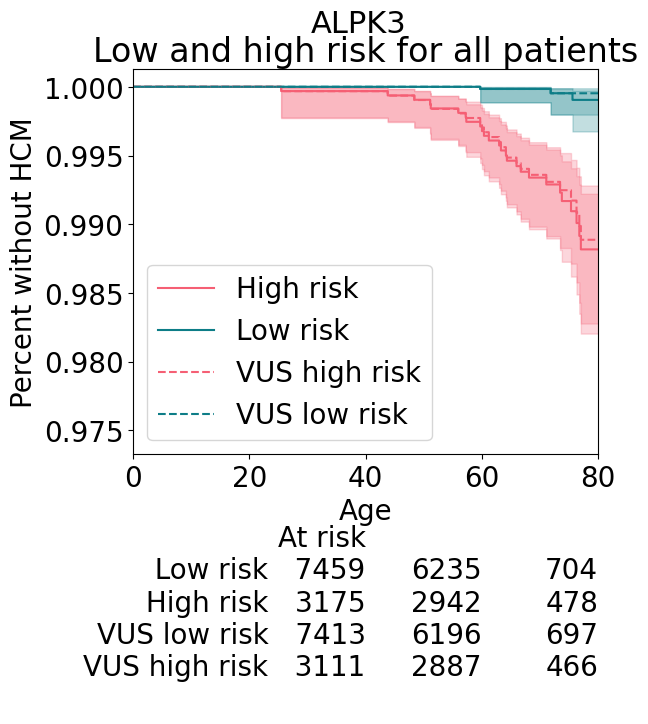

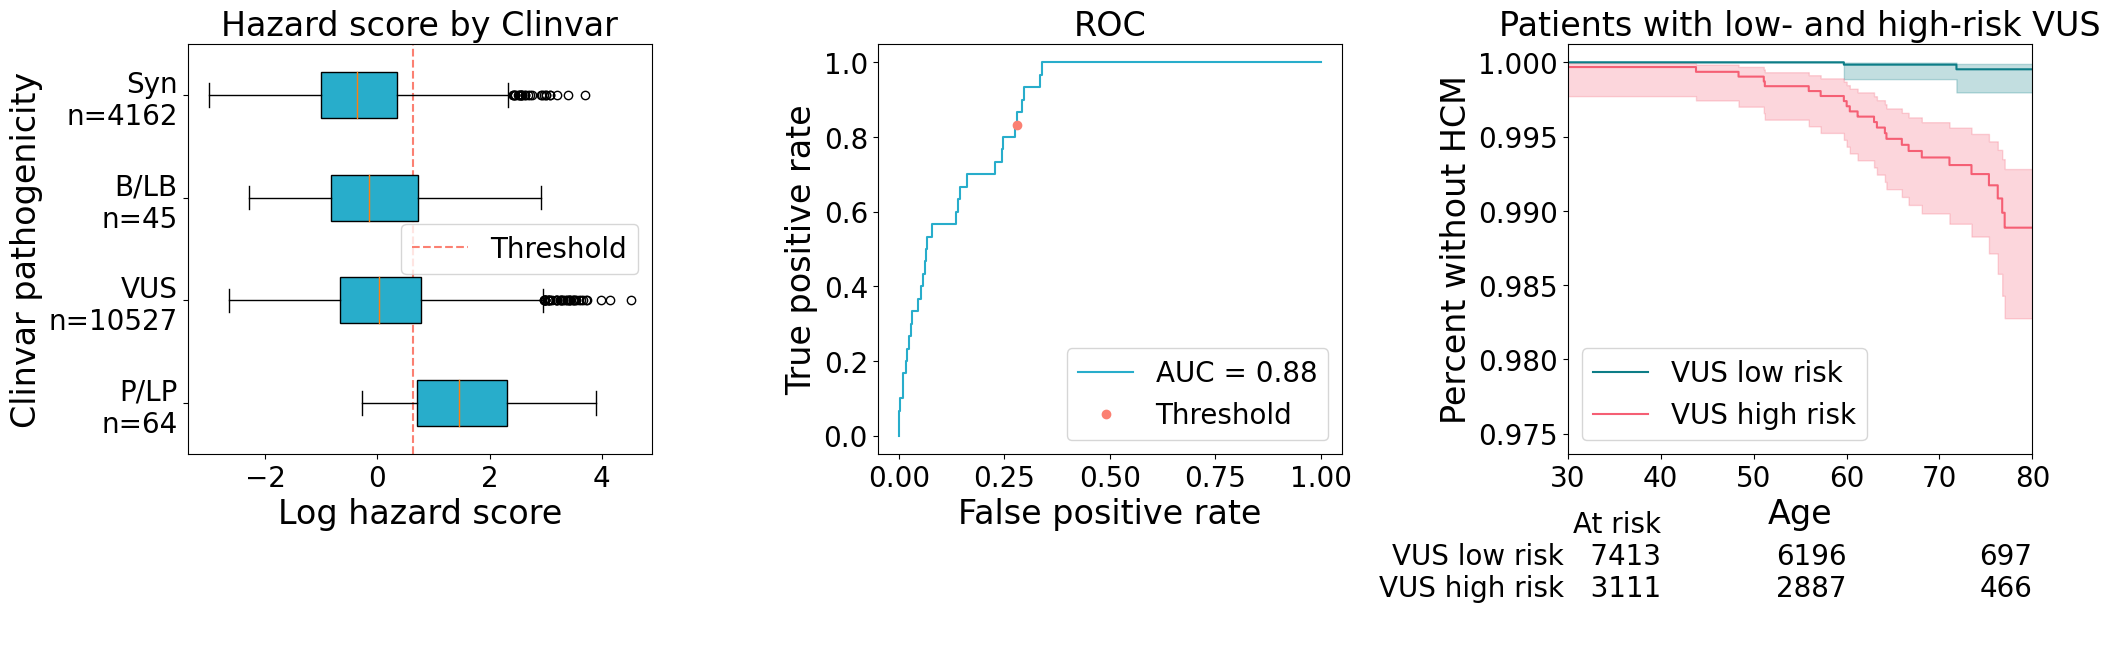

FLNC
Model with all features


<lifelines.CoxPHFitter: fitted with 17076 total observations, 17040 right-censored observations>
             duration col = 'duration'
                event col = 'is_HCM'
                penalizer = 0.001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 17076
number of events observed = 36
   partial log-likelihood = -300.07
         time fit was run = 2024-07-02 15:28:25 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
am_pathogenicity -0.22      0.80      0.51           -1.23            0.79                0.29                2.20
cadd_raw_score    0.66      1.93      1.33           -1.95            3.27                0.14               26.27
faf_max          -0.73      0.48      0.56           -1.82            0.37                0.16                1.44
phylop            0.11      1.11      0.78           -1.43            1.64                0.24                5.17
spliceai_ds_max  -1.27      0.28      1.30           -3.82            1.28                0.02                3.59
revel_max         0.87      2.39      0.60           -0.30            2.05                0.74                7.74
is_HTN            0.78      2.18      0.31            0.17            1.39                1.18                4.00
is_AF             2.15      8.58      0.34            1.49            2.81                4.45               16.56
prs_score         2.78     16.18      1.23            0.37            5.19                1.45              180.14
sex               0.36      1.44      0.28           -0.20            0.92                0.82                2.51
is_family_hist    0.14      1.15      0.28           -0.40            0.68                0.67                1.98

                  cmp to     z      p  -log2(p)
covariate                                      
am_pathogenicity    0.00 -0.43   0.67      0.59
cadd_raw_score      0.00  0.50   0.62      0.69
faf_max             0.00 -1.30   0.19      2.37
phylop              0.00  0.14   0.89      0.16
spliceai_ds_max     0.00 -0.98   0.33      1.61
revel_max           0.00  1.45   0.15      2.77
is_HTN              0.00  2.50   0.01      6.35
is_AF               0.00  6.41 <0.005     32.71
prs_score           0.00  2.26   0.02      5.41
sex                 0.00  1.27   0.20      2.30
is_family_hist      0.00  0.50   0.62      0.70
---
Concordance = 0.84
Partial AIC = 622.15
log-likelihood ratio test = 67.38 on 11 df
-log2(p) of ll-ratio test = 31.28

<lifelines.CoxPHFitter: fitted with 10704 total observations, 10676 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 10704
number of events observed = 28
   partial log-likelihood = -226.02
         time fit was run = 2024-07-02 15:28:28 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
is_highest  2.42     11.28      0.39            1.66            3.18                5.27               24.14

            cmp to    z      p  -log2(p)
covariate                               
is_highest    0.00 6.24 <0.005     31.10
---
Concordance = 0.74
Partial AIC = 454.03
log-likelihood ratio test = 37.07 on 1 df
-log2(p) of ll-ratio test = 29.71

Threshold by percentile:  90
Number of VUS above threshold:  994


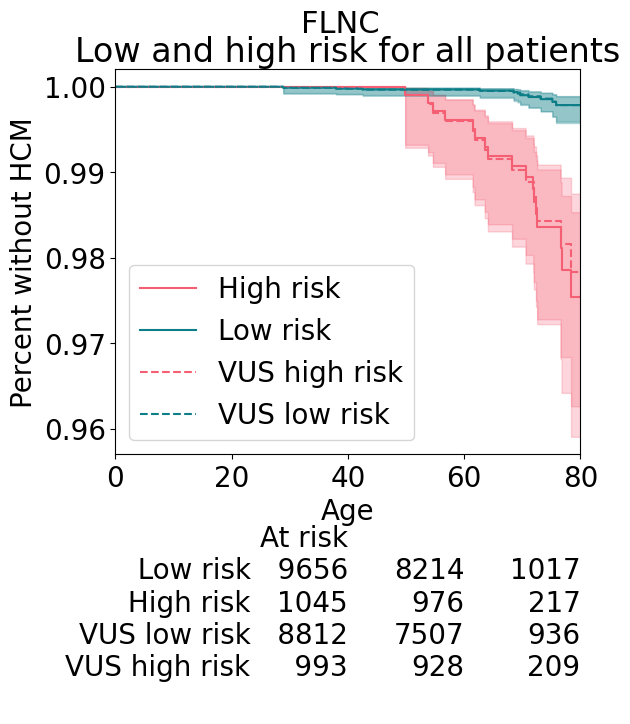

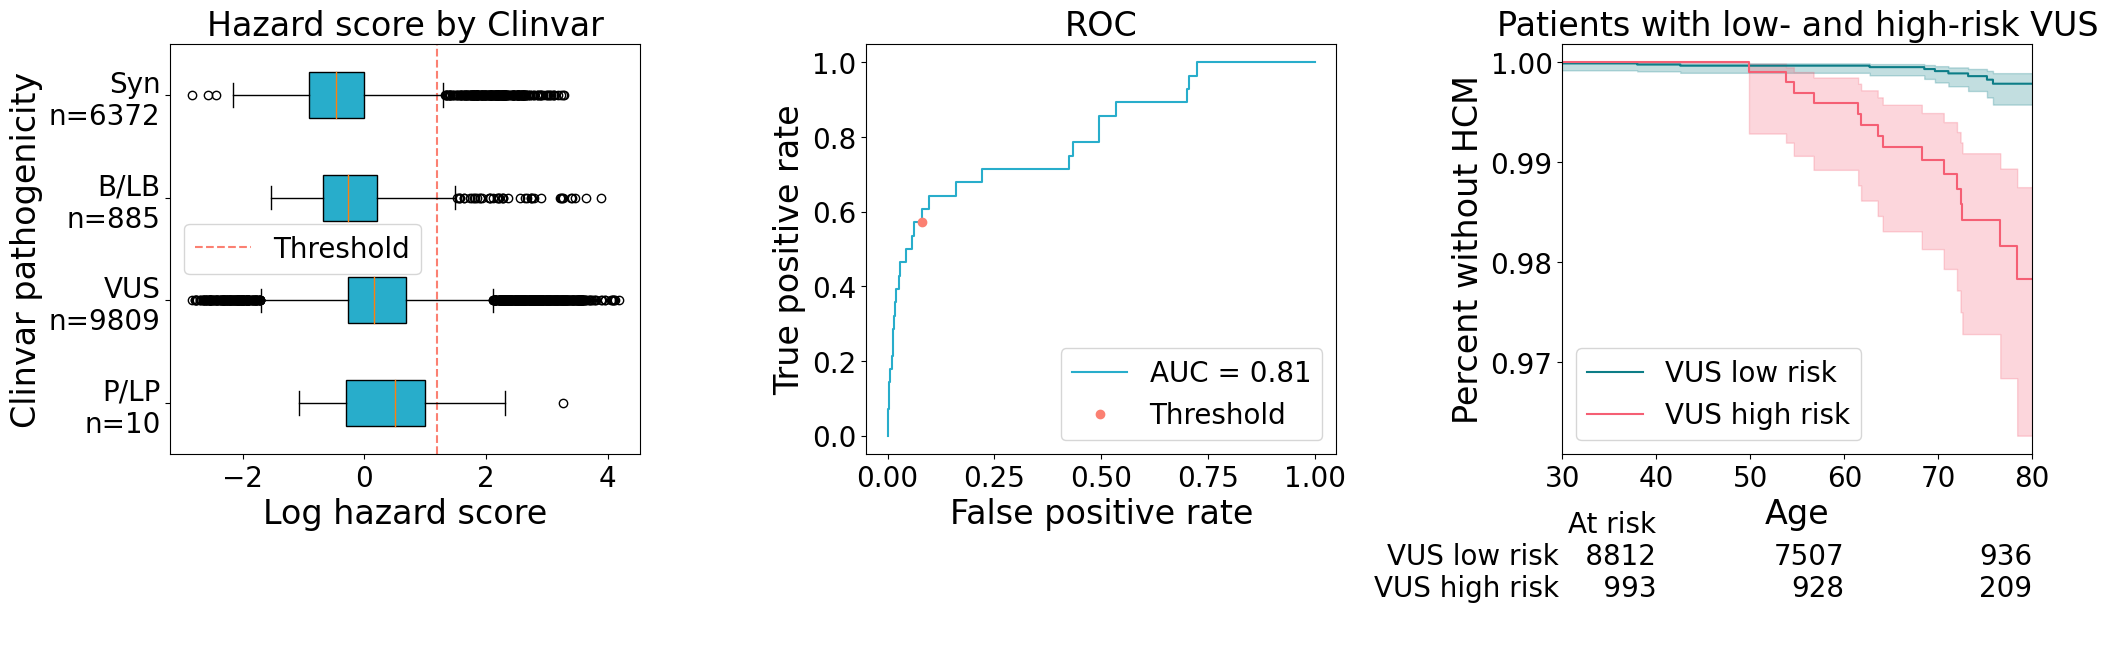

MYBPC3
Model with all features


<lifelines.CoxPHFitter: fitted with 11015 total observations, 10955 right-censored observations>
             duration col = 'duration'
                event col = 'is_HCM'
                penalizer = 0.001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 11015
number of events observed = 60
   partial log-likelihood = -447.06
         time fit was run = 2024-07-02 15:29:15 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
am_pathogenicity  1.94      6.98      0.44            1.08            2.80                2.96               16.46
cadd_raw_score    4.18     65.32      0.94            2.34            6.02               10.38              411.19
faf_max          -1.72      0.18      0.53           -2.76           -0.69                0.06                0.50
phylop           -2.97      0.05      0.62           -4.18           -1.76                0.02                0.17
spliceai_ds_max   0.55      1.73      0.55           -0.53            1.62                0.59                5.05
revel_max         0.29      1.34      0.52           -0.73            1.31                0.48                3.70
is_HTN            0.41      1.51      0.26           -0.10            0.92                0.91                2.51
is_AF             1.52      4.57      0.29            0.95            2.09                2.58                8.10
prs_score         3.99     54.08      1.08            1.88            6.10                6.54              447.16
sex               0.55      1.74      0.25            0.06            1.05                1.06                2.85
is_family_hist    0.42      1.52      0.24           -0.06            0.90                0.94                2.45

                  cmp to     z      p  -log2(p)
covariate                                      
am_pathogenicity    0.00  4.44 <0.005     16.73
cadd_raw_score      0.00  4.45 <0.005     16.85
faf_max             0.00 -3.26 <0.005      9.79
phylop              0.00 -4.79 <0.005     19.22
spliceai_ds_max     0.00  1.00   0.32      1.65
revel_max           0.00  0.56   0.58      0.80
is_HTN              0.00  1.59   0.11      3.16
is_AF               0.00  5.20 <0.005     22.24
prs_score           0.00  3.70 <0.005     12.19
sex                 0.00  2.21   0.03      5.20
is_family_hist      0.00  1.71   0.09      3.53
---
Concordance = 0.89
Partial AIC = 916.12
log-likelihood ratio test = 179.97 on 11 df
-log2(p) of ll-ratio test = 106.25

<lifelines.CoxPHFitter: fitted with 7910 total observations, 7855 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 7910
number of events observed = 55
   partial log-likelihood = -422.33
         time fit was run = 2024-07-02 15:29:18 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
is_highest  2.94     18.91      0.28            2.38            3.50               10.84               32.97

            cmp to     z      p  -log2(p)
covariate                                
is_highest    0.00 10.36 <0.005     81.14
---
Concordance = 0.79
Partial AIC = 846.67
log-likelihood ratio test = 105.15 on 1 df
-log2(p) of ll-ratio test = 79.54

Threshold by percentile:  91
Number of VUS above threshold:  524


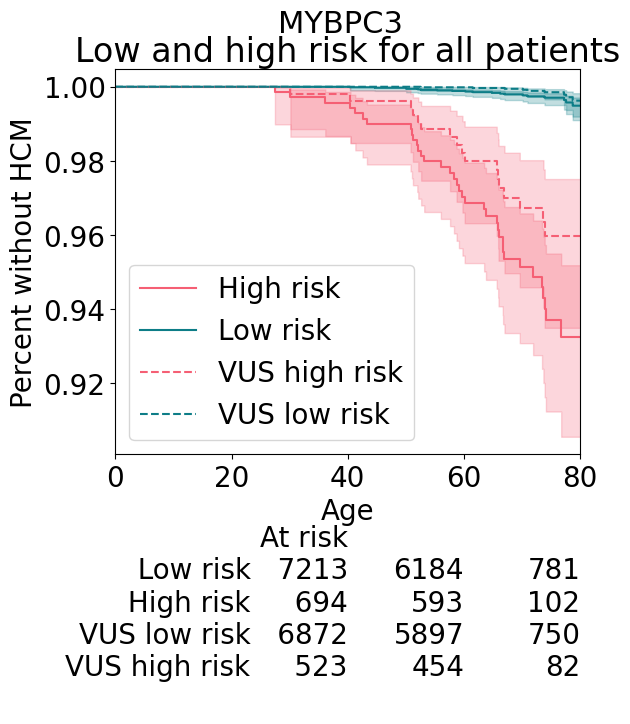

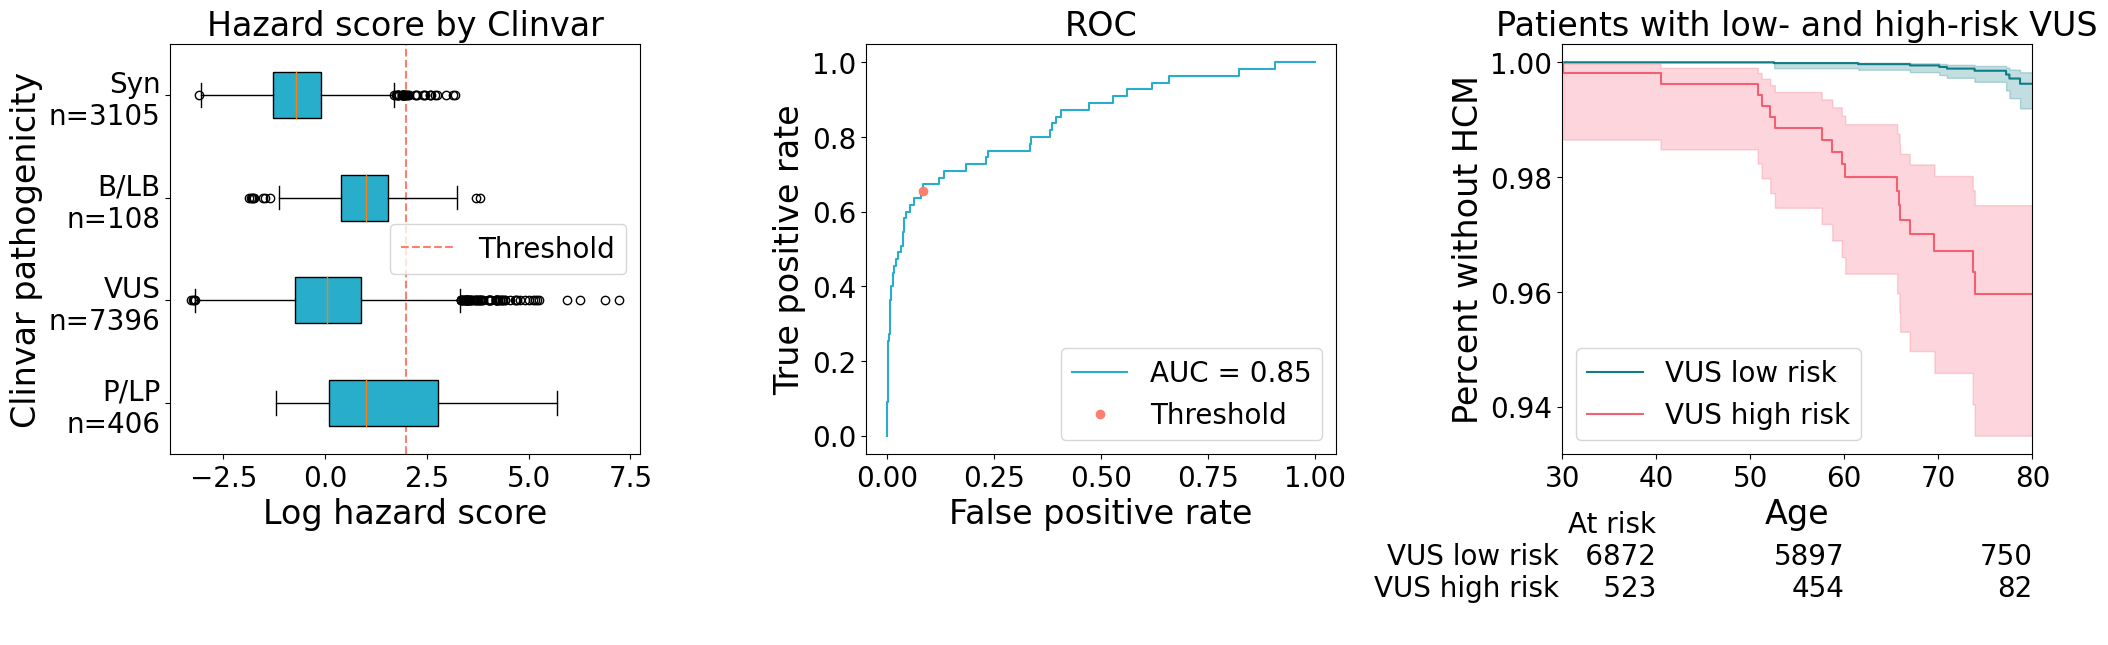

MYH7
Model with all features


<lifelines.CoxPHFitter: fitted with 11620 total observations, 11565 right-censored observations>
             duration col = 'duration'
                event col = 'is_HCM'
                penalizer = 0.001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 11620
number of events observed = 55
   partial log-likelihood = -424.33
         time fit was run = 2024-07-02 15:30:02 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
am_pathogenicity -0.07      0.93      0.40           -0.86            0.72                0.42                2.05
cadd_raw_score    1.21      3.36      1.27           -1.28            3.71                0.28               40.85
faf_max          -0.64      0.53      0.66           -1.94            0.66                0.14                1.93
phylop            1.51      4.50      0.86           -0.18            3.19                0.83               24.33
spliceai_ds_max  -2.18      0.11      1.41           -4.94            0.58                0.01                1.79
revel_max         1.65      5.20      0.54            0.58            2.72                1.79               15.11
is_HTN            0.34      1.40      0.26           -0.18            0.85                0.84                2.34
is_AF             1.91      6.75      0.29            1.35            2.47                3.85               11.86
prs_score         3.64     38.02      1.10            1.47            5.80                4.36              331.42
sex               0.13      1.14      0.25           -0.36            0.62                0.70                1.85
is_family_hist    0.71      2.04      0.26            0.20            1.22                1.23                3.40

                  cmp to     z      p  -log2(p)
covariate                                      
am_pathogenicity    0.00 -0.18   0.86      0.22
cadd_raw_score      0.00  0.95   0.34      1.55
faf_max             0.00 -0.97   0.33      1.58
phylop              0.00  1.75   0.08      3.64
spliceai_ds_max     0.00 -1.55   0.12      3.03
revel_max           0.00  3.03 <0.005      8.67
is_HTN              0.00  1.28   0.20      2.33
is_AF               0.00  6.65 <0.005     35.01
prs_score           0.00  3.29 <0.005      9.98
sex                 0.00  0.52   0.60      0.73
is_family_hist      0.00  2.75   0.01      7.38
---
Concordance = 0.90
Partial AIC = 870.66
log-likelihood ratio test = 121.43 on 11 df
-log2(p) of ll-ratio test = 66.53

<lifelines.CoxPHFitter: fitted with 5268 total observations, 5221 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 5268
number of events observed = 47
   partial log-likelihood = -351.13
         time fit was run = 2024-07-02 15:30:05 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
is_highest  2.22      9.19      0.34            1.56            2.87                4.77               17.72

            cmp to    z      p  -log2(p)
covariate                               
is_highest    0.00 6.62 <0.005     34.70
---
Concordance = 0.75
Partial AIC = 704.25
log-likelihood ratio test = 52.66 on 1 df
-log2(p) of ll-ratio test = 41.20

Threshold by percentile:  78
Number of VUS above threshold:  946


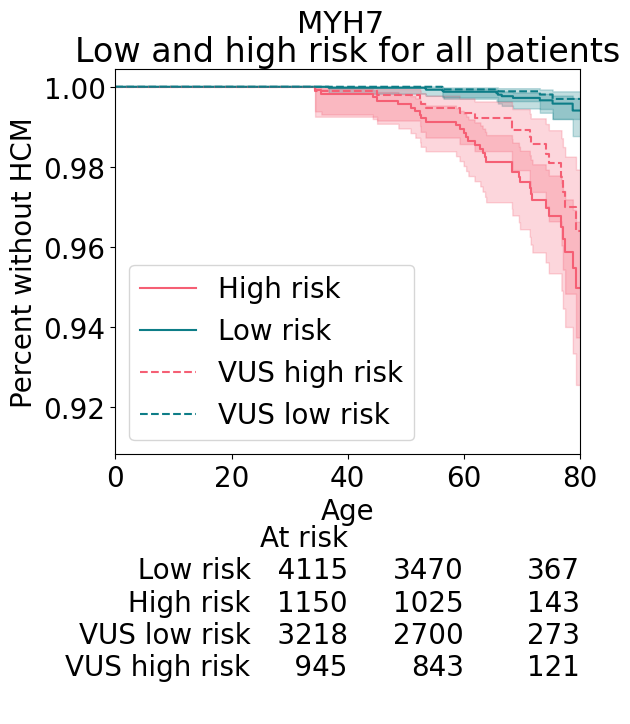

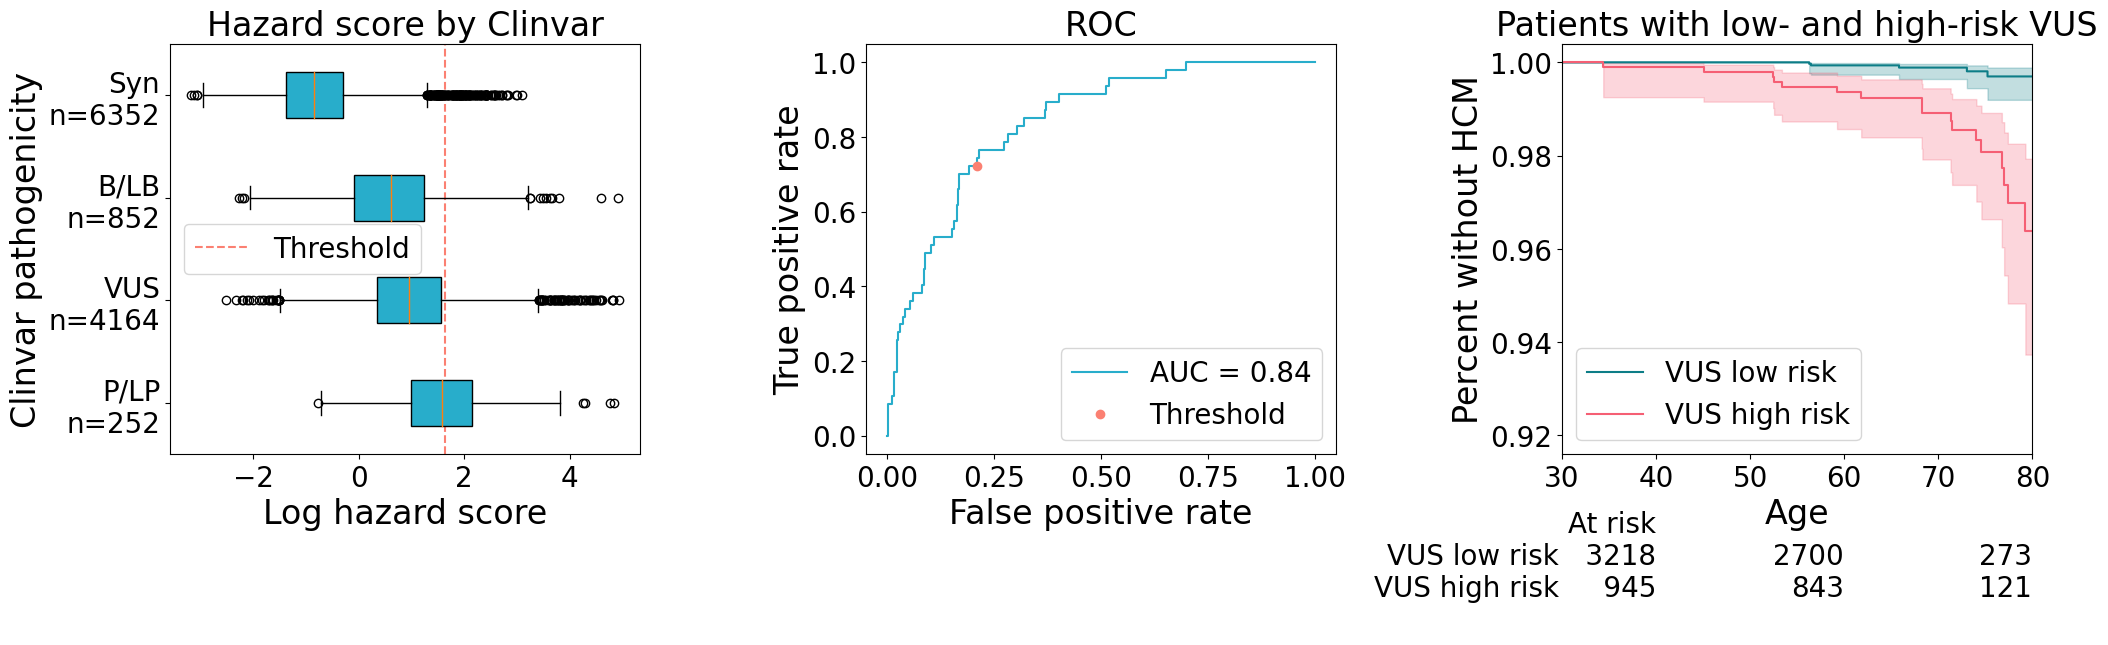

,Gene,Threshold,Partial hazard for all patients,P-value for all patients,Partial hazard for patients with VUS,P-value for patients with VUS,Num. carrier cases
0,ALPK3,70,18,2.5e-06,25,1.2e-05,30
1,FLNC,90,11,4.3e-10,11,7.6e-09,28
2,MYBPC3,91,19,3.7e-25,23,3.9e-14,55
3,MYH7,78,9.2,3.6e-11,10,4.5e-06,47


In [60]:
find_threshold_vals(gene_list)